In [0]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output


from collections  import OrderedDict
from collections import namedtuple
from itertools import product


torch.set_printoptions(linewidth=120)

### Load the dataset

In [2]:
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

0it [00:00, ?it/s]

26427392it [00:07, 3761199.74it/s]                               


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 94553.99it/s]                            
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


4423680it [00:01, 4078638.93it/s]                             
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


8192it [00:00, 31349.41it/s]            

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


In [0]:
loader = torch.utils.data.DataLoader(train_set, batch_size = 1)
# type(loader.dataset[0][0])  # this is to access one of the images.
# type(loader.dataset[0][1])  # this is to access the label.

In [0]:
images = loader.dataset[10][0]
# images.size()

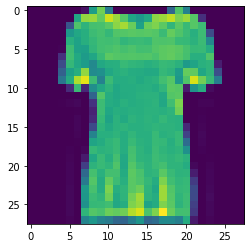

In [5]:
images.size()
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(images[0, :, :].numpy())

### Build the network

In [0]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 12*4*4)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t


In [0]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)

    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

    self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

    self.fc1 = nn.Linear(in_features=64*7*7, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=64)
    self.out = nn.Linear(in_features=64, out_features=10)

  # define forward function
  def forward(self, t):

    t = F.relu(self.conv1(t))
    t = F.relu(self.conv2(t))
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    t = F.relu(self.conv3(t))
    t = F.relu(self.conv4(t))
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    t = F.relu(self.conv5(t))
    t = F.relu(self.conv6(t))

    # fc1
    t = t.reshape(-1, t.shape[1]*t.shape[2]*t.shape[3])
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t

In [8]:
# Network sanity check.
x = loader.dataset[0][0]
x = x.unsqueeze(0)
model = Network()
y = model(x)

print(x.shape)
print(y.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 10])


In [9]:
cuda = torch.device("cuda")

modelGPU = Network().to(device=cuda)
y = modelGPU(x.to(device=cuda))

y.shape

torch.Size([1, 10])

In [0]:
# Store hyperparameters in a dictionary.

# params = OrderedDict(
#     lr = [.01, .001],
#     batch_size = [100, 1000],
#     shuffle = [True, False]
# )

params = OrderedDict(
    lr = [.01],
    batch_size = [100],
    shuffle = [True]
)

epochs = 25

### RunBuilder

In [0]:
# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

### RunManager

In [0]:
# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json.
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images)

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images.to(device=cuda))

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further analysis
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)


### Training (CPU)

In [0]:
# m = RunManager()

# # get all runs from params using RunBuilder class
# for run in RunBuilder.get_runs(params):

#     # if params changes, following line of code should reflect the changes too
#     network = Network()
#     loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
#     optimizer = optim.Adam(network.parameters(), lr=run.lr)

#     m.begin_run(run, network, loader)
#     for epoch in range(epochs):
      
#       m.begin_epoch()
#       for batch in loader:
        
#         images = batch[0]
#         labels = batch[1]
#         preds = network(images)
#         loss = F.cross_entropy(preds, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         m.track_loss(loss)
#         m.track_num_correct(preds, labels)

#       m.end_epoch()
#     m.end_run()

# # when all runs are done, save results to files
# m.save('results')

### Training (GPU)

In [25]:
m = RunManager()

# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    networkGPU = Network().to(device=cuda)
    loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    optimizer = optim.Adam(networkGPU.parameters(), lr=run.lr)

    m.begin_run(run, networkGPU, loader)
    for epoch in range(epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0].to(device=cuda)
        labels = batch[1]
        preds = networkGPU(images)
        #print("\n", "QQQQQ", "\n")
        preds = preds.cpu()
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      m.end_epoch()
    m.end_run()

# when all runs are done, save results to files
m.save('results')


,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,0.689463,0.734500,13.694653,13.855547,0.01,100,True
1,1,2,0.417593,0.844150,13.668971,27.781739,0.01,100,True
2,1,3,0.375741,0.859583,13.847923,41.898382,0.01,100,True
3,1,4,0.352348,0.866400,13.740108,55.897347,0.01,100,True
4,1,5,0.350492,0.869800,13.711618,69.864850,0.01,100,True
5,1,6,0.344196,0.871150,13.682228,83.808920,0.01,100,True
6,1,7,0.339486,0.873017,13.711214,97.819330,0.01,100,True
7,1,8,0.337416,0.874917,13.645008,111.751872,0.01,100,True
8,1,9,0.330341,0.877433,13.625719,125.658743,0.01,100,True
9,1,10,0.329936,0.876883,13.574610,139.516532,0.01,100,True


### TensorBoard

In [15]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-11-23 12:49:53--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.237.203.145, 3.228.157.109, 34.193.139.214, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.237.203.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  37.6MB/s    in 0.3s    

2019-11-23 12:49:53 (37.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './runs'
get_ipython().system_raw(
'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
.format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [28]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
"import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://f3b256b1.ngrok.io


In [0]:
# !rm -r runs/Nov*